# Exploratory Project Looking at Drug Related Deaths in CT

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import datetime as dt
import matplotlib.pyplot as plt
from scipy import *
import geopandas as gpd
from shapely.geometry import Polygon

### Importing Data

In [2]:
raw_data = pd.read_csv("accidental_drug_deaths_CT.csv")
print(raw_data.info())
print(raw_data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12963 entries, 0 to 12962
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           12963 non-null  object 
 1   Date Type                      12963 non-null  object 
 2   Age                            12961 non-null  float64
 3   Sex                            12954 non-null  object 
 4   Race                           12897 non-null  object 
 5   Ethnicity                      3435 non-null   object 
 6   Residence City                 12320 non-null  object 
 7   Residence County               11655 non-null  object 
 8   Residence State                10927 non-null  object 
 9   Injury City                    12706 non-null  object 
 10  Injury County                  9527 non-null   object 
 11  Injury State                   9849 non-null   object 
 12  Injury Place                   12573 non-null 

- There are 12,000+ individuals' worth of data from 1st Jan 2012 to 31st Dec 2024

### Formatting Data

In [3]:
# converting date to datetime
raw_data['Date'] = pd.to_datetime(raw_data['Date'], format = '%m/%d/%Y')

In [4]:
# creating age range levels
bins = [12, 19, 26, 36, 46, 56, 66, np.inf]
labels = ['12-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']

raw_data['Age_Range'] = pd.cut(raw_data['Age'], bins=bins, labels=labels, right=False)

print(raw_data[['Age', 'Age_Range']])

        Age Age_Range
0      65.0     56-65
1      42.0     36-45
2      34.0     26-35
3      34.0     26-35
4      43.0     36-45
...     ...       ...
12958  48.0     46-55
12959  53.0     46-55
12960  31.0     26-35
12961  66.0       66+
12962  53.0     46-55

[12963 rows x 2 columns]


In [5]:
# converting Y's to boolean 1 and 0s
raw_data.iloc[:, 23:45] = raw_data.iloc[:, 23:45].replace({'Y': 1, 'N': 0}).fillna('NA')
raw_data['Heroin'] = raw_data['Heroin'].replace({'Y': 1, 'N': 0}).fillna(np.nan)

/var/folders/jl/6cpcgscn66v90thk48s_d56r0000gn/T/ipykernel_64459/1676945848.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_data.iloc[:, 23:45] = raw_data.iloc[:, 23:45].replace({'Y': 1, 'N': 0}).fillna('NA')
/var/folders/jl/6cpcgscn66v90thk48s_d56r0000gn/T/ipykernel_64459/1676945848.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_data['Heroin'] = raw_data['Heroin'].replace({'Y': 1, 'N': 0}).fillna(np.nan)


In [6]:
# replacing all NaN with NA
raw_data = raw_data.replace('UNKNOWN', np.nan)
raw_data = raw_data.replace('NA', np.nan).infer_objects(copy=False)
raw_data['Sex'] = raw_data['Sex'].replace(['X', 'Unknown'], np.nan)


/var/folders/jl/6cpcgscn66v90thk48s_d56r0000gn/T/ipykernel_64459/2173107793.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_data = raw_data.replace('NA', np.nan).infer_objects(copy=False)


In [7]:
# cleaning Ethnicity column options

raw_data['Ethnicity'].unique()

ethnicity_replacements = {
    'Yes, Mexican, Mexican American, Chicano': 'Mexican',
    'Mexican, Mexican American, Chicano': 'Mexican',
    'Yes, Puerto Rican': 'Puerto Rican',
    'Puerto Rican': 'Puerto Rican',
    'Yes, Cuban': 'Cuban',
    'Cuban': 'Cuban',
    'Yes, other Spanish/Hispanic/Latino': 'Other Hispanic/Latino',
    'Yes, Other Spanish/Hispanic/Latino (Specify)': 'Other Hispanic/Latino',
    'Spanish/Hispanic/Latino': 'Other Hispanic/Latino',
    'Hispanic': 'Other Hispanic/Latino',
    'Other Spanish/Hispanic/Latino': 'Other Hispanic/Latino',
    'No, not Spanish/Hispanic/Latino': 'Not Hispanic/Latino',
    'Not Spanish/Hispanic/Latino': 'Not Hispanic/Latino',
    'NA': np.nan,
    'n': np.nan,
    'Unknown': np.nan
}

raw_data['Ethnicity'] = raw_data['Ethnicity'].replace(ethnicity_replacements)

raw_data['Ethnicity'].unique()

array(['Not Hispanic/Latino', nan, 'Other Hispanic/Latino',
       'Puerto Rican', 'Mexican', 'Cuban'], dtype=object)

In [8]:
raw_data['Race'].unique()


array(['White', nan, 'white', 'Black or African American', 'Asian Indian',
       'Other Asian (Specify)', 'Other (Specify)', 'Asian',
       'Asian/Indian', 'Unknown', 'Other', 'Other Asian',
       'Other (Specify) Haitian', 'Black',
       'Other (Specify) portugese, Cape Verdean',
       'Other (Specify) Puerto Rican',
       'Black or African American / American Indian Lenni Lenape',
       'American Indian or Alaska Native', 'Asian, Other', 'Hawaiian',
       'Native American, Other', 'Chinese', 'Korean', 'Japanese'],
      dtype=object)

In [9]:

race_replacements = {
    'white': 'White',
    'Black': 'Black or African American',
    'Asian, Other': 'Asian',
    'Other Asian (Specify)': 'Asian',
    'Other (Specify)': 'Other',
    'Asian/Indian': 'Mixed', 
    'Cape Verdean': 'African',
    'Black or African American / American Indian Lenni Lenape': 'Mixed',
    'Other (Specify) portugese, Cape Verdean': 'Mixed',
    'Hawaiian': 'Pacific Islander',
    'American Indian or Alaska Native': 'American Indian',
    'Native American, Other': 'Native American',
    'Other (Specify) Puerto Rican': 'Caribbean',
    'Other (Specify) Haitian': 'Caribbean',
    'NA': np.nan,
    'n': np.nan,
    'Unknown': np.nan
}

raw_data['Race'] = raw_data['Race'].replace(race_replacements)

raw_data['Race'].unique()


array(['White', nan, 'Black or African American', 'Asian Indian', 'Asian',
       'Other', 'Mixed', 'Other Asian', 'Caribbean', 'American Indian',
       'Pacific Islander', 'Native American', 'Chinese', 'Korean',
       'Japanese'], dtype=object)

In [10]:
# cleaning geographical coordinate columns

pattern = r"(.+?),.*\n(\(.*\))"

raw_data[['InjuryCity', 'InjuryCityGeo']] = raw_data['InjuryCityGeo'].str.extract(pattern, expand=True)
raw_data[['DeathCity', 'DeathCityGeo']] = raw_data['DeathCityGeo'].str.extract(pattern, expand=True)

In [11]:
raw_data['Location if Other'].head()

0             NaN
1             NaN
2             NaN
3             NaN
4    Mohegan Park
Name: Location if Other, dtype: object

In [12]:
raw_data['Location'].head()
raw_data['Location'].unique()

array([nan, 'Decedent’s Home', 'Other (Specify)',
       'Hospital - ER/Outpatient', 'Hospital - Inpatient',
       'Hospital - Dead On Arrival', 'Hiospital', 'Nursing Home',
       'Hospice Facility', 'Residence', 'Hospital', 'Other',
       'Convalescent Home', 'Assisted Living', 'Shelter', 'Hospice',
       "Decedent's Home"], dtype=object)

In [13]:
# cleaning specific location

other_location = raw_data['Location'] == "Other (Specify)"
raw_data.loc[other_location, 'Location'] = raw_data['Location if Other']

In [14]:
raw_data['Location_Cleaned'] = raw_data['Location'].replace('nan', np.nan)
raw_data['Location_Cleaned'] = raw_data['Location'].str.lower()

In [15]:
# string matching to group locations together

string_conditions = [
    raw_data['Location_Cleaned'].str.contains("decedent's home", na=False), # want to keep this separate
    raw_data['Location_Cleaned'].str.contains('^residence$', na=False), # Exact match
    raw_data['Location_Cleaned'].str.contains('hotel|motel|inn|western', na=False),
    raw_data['Location_Cleaned'].str.contains('vehicle|car|camper|rv', na=False),
    raw_data['Location_Cleaned'].str.contains('hospital|ward|hospice|assisted', na=False),
    raw_data['Location_Cleaned'].str.contains('residence|house|home|apartment|porch|backyard|farm|basement|acquaintance|friend', na=False), # More general friend's home
    raw_data['Location_Cleaned'].str.contains('lot|store|station|overpass|park|area|woods|building|roadway|sidewalk|laundromat|field|bridge|outside|wooded|employment|buisness|hallway|stairwell|plaza|marina|business|alleyway|garage|super|homeless', na=False),
    raw_data['Location_Cleaned'].str.contains('halfway|facility|shelter|institution|center|corrections|church|', na=False)
]

location_groups = [
    "Decedent's Home",
    "Own Residence",
    'Hotel/Motel',
    'Vehicle',
    'Hospital',
    'Other Residence', # Now a separate category
    'Public Space',
    'Institution/Shelter'
]

raw_data['Location_Cleaned'] = np.select(string_conditions, location_groups, default='Unspecified')



In [16]:
raw_data['Location_Cleaned'].unique()


array(['Unspecified', 'Other Residence', 'Public Space', 'Hospital',
       'Hotel/Motel', 'Own Residence', 'Vehicle', 'Institution/Shelter',
       "Decedent's Home"], dtype=object)

In [17]:
others = raw_data[raw_data['Location_Cleaned'] == 'Other']

# these are all missing

In [18]:
raw_data.isnull().sum()
len(raw_data)

12963

In [19]:
deaths = raw_data[raw_data['Date Type'] == 'Date of death']
deaths.count()

Date                             11196
Date Type                        11196
Age                              11195
Sex                              11185
Race                             11075
Ethnicity                         3209
Residence City                   10619
Residence County                  9995
Residence State                   9237
Injury City                      10766
Injury County                     8517
Injury State                      8825
Injury Place                     10825
Description of Injury            11117
Death City                        7430
Death County                      6343
Death State                       5108
Location                          8870
Location if Other                 1009
Cause of Death                   11196
Manner of Death                  11190
Other Significant Conditions      1344
Heroin                            2748
Heroin death certificate (DC)      340
Cocaine                           4640
Fentanyl                 

In [20]:
raw_data['Date Type'].unique()

array(['Date of death', 'Date reported'], dtype=object)

In [21]:
data_check = raw_data.head(15)
data_check.to_csv('data_check.csv')

### Basic Demographics

#### Age

In [22]:
print(f"There are {raw_data['Age'].isnull().sum()} NANs")
print(f"Min age: {raw_data['Age'].min()}")
print(f"Max age: {raw_data['Age'].max()}")

There are 2 NANs
Min age: 13.0
Max age: 87.0


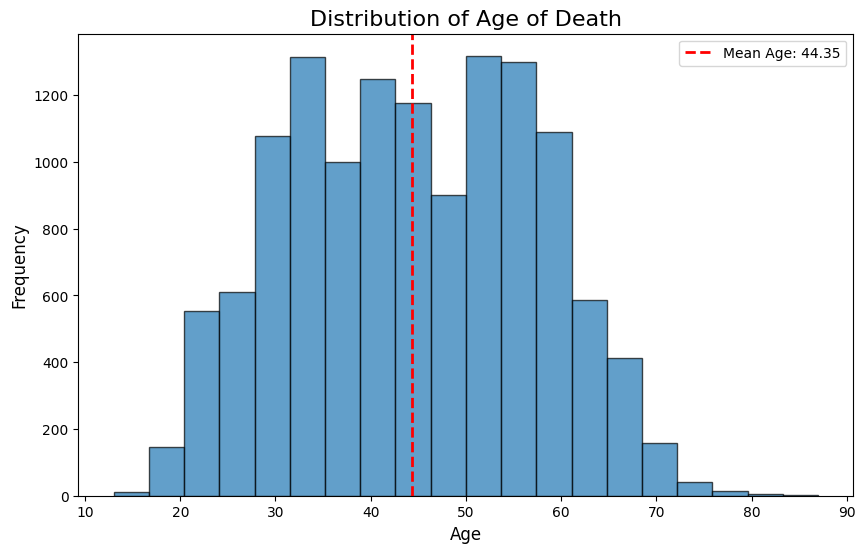

In [23]:
### Plot

mean_age = raw_data['Age'].mean(skipna=True)
fig, ax = plt.subplots(figsize=(10, 6))

raw_data['Age'].hist(ax=ax, bins=20, edgecolor='black', alpha=0.7)
ax.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Mean Age: {mean_age:.2f}')

ax.set_title('Distribution of Age of Death', fontsize=16)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

ax.legend()
ax.grid(False)

plt.savefig('age_histogram_with_mean.png')
plt.show()



- Mean age of death is around 45 years of age.
- There is a range of 13-87 years of age.

#### Location of Death

In [24]:
raw_data['Location_Cleaned_Plot'] = raw_data['Location_Cleaned'].replace('nan', np.nan)
location_counts = raw_data['Location_Cleaned_Plot'].value_counts()

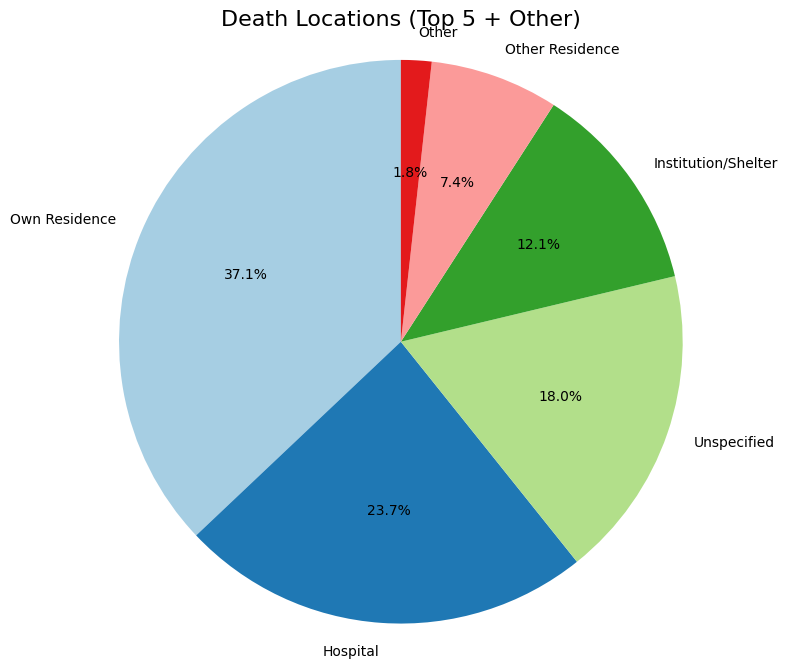

In [25]:
top_5 = location_counts.head(5)

other_count = location_counts.iloc[5:].sum()

plot_data = pd.concat([top_5, pd.Series({'Other': other_count})])

fig, ax = plt.subplots(figsize=(8, 8))
plot_data.plot.pie(
    ax=ax,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)

ax.set_title('Death Locations (Top 5 + Other)', fontsize=16)
ax.set_ylabel('')

ax.axis('equal')

plt.savefig('top5_locations_pie_chart.png')
plt.show()



- Location of most deaths is in the home (own place of residence), followed by medical facilities (mostly hospitals but also includes hospices, wards, assisted living)
- A lot of missing data (18% unspecified locations)

#### Geographical Location in CT

#### Gender

In [26]:
males = raw_data[raw_data['Sex'] == "Male"]
print(f"There are {len(males)} males")

females = raw_data[raw_data['Sex'] == "Female"]
print(f"There are {len(females)} females")

# mean age of death for males very similar

print(f"Mean age of death (males): {males['Age'].mean()}")
print(f"Mean age of death (females): {females['Age'].mean()}")



There are 9571 males
There are 3380 females
Mean age of death (males): 44.2833855799373
Mean age of death (females): 44.55355029585799


#### Ethnicity

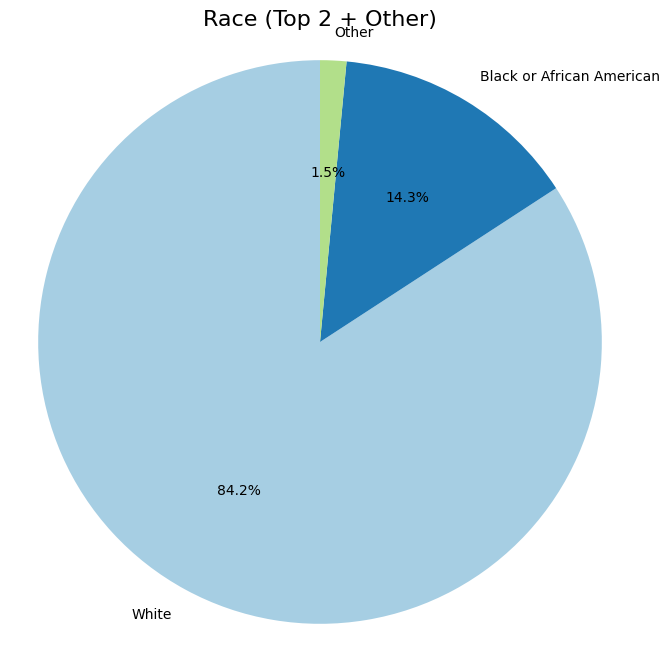

In [27]:
race_counts = raw_data['Race'].value_counts()
top_5 = race_counts.head(2)

other_count = race_counts.iloc[2:].sum()

plot_data = pd.concat([top_5, pd.Series({'Other': other_count})])

fig, ax = plt.subplots(figsize=(8, 8))
plot_data.plot.pie(
    ax=ax,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)

ax.set_title('Race (Top 2 + Other)', fontsize=16)
ax.set_ylabel('')

ax.axis('equal')

plt.savefig('top2_race_pie_chart.png')
plt.show()



In [28]:
top_5 = race_counts.head(5)
print(top_5)


Race
White                        10805
Black or African American     1836
Other                           98
Asian Indian                    31
Asian                           29
Name: count, dtype: int64


- Majority of deaths are of White individuals (10805), then Black/African Americans (1836)


### Drug Deaths Over the Years

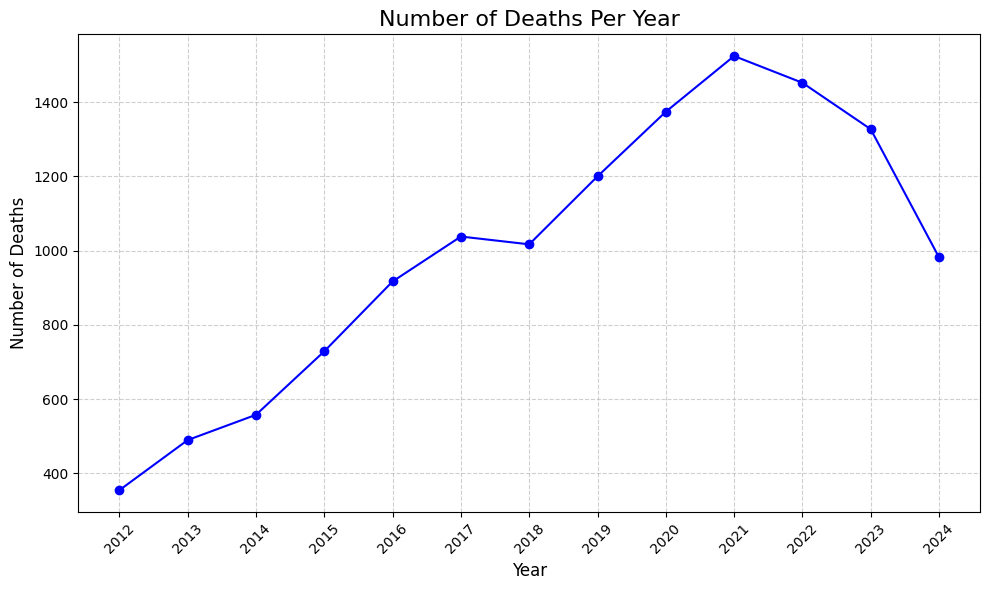

In [29]:
raw_data['Year'] = raw_data['Date'].dt.year

deaths_per_year = raw_data['Year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(deaths_per_year.index, deaths_per_year.values, marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title('Number of Deaths Per Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Deaths', fontsize=12)

# Ensure integer ticks on the x-axis
ax.set_xticks(deaths_per_year.index)
ax.tick_params(axis='x', rotation=45)

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()

plt.savefig('deaths_per_year.png')
plt.show()



- The numnber of deaths per year climbed steadily, peaking in 2021. 
- The number of deaths per year has been declining since 2021. 

#### Age and Number of Deaths Per Year

/var/folders/jl/6cpcgscn66v90thk48s_d56r0000gn/T/ipykernel_64459/2770208487.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deaths_by_age_year = raw_data.groupby(['Year', 'Age_Range']).size().unstack(fill_value=0)


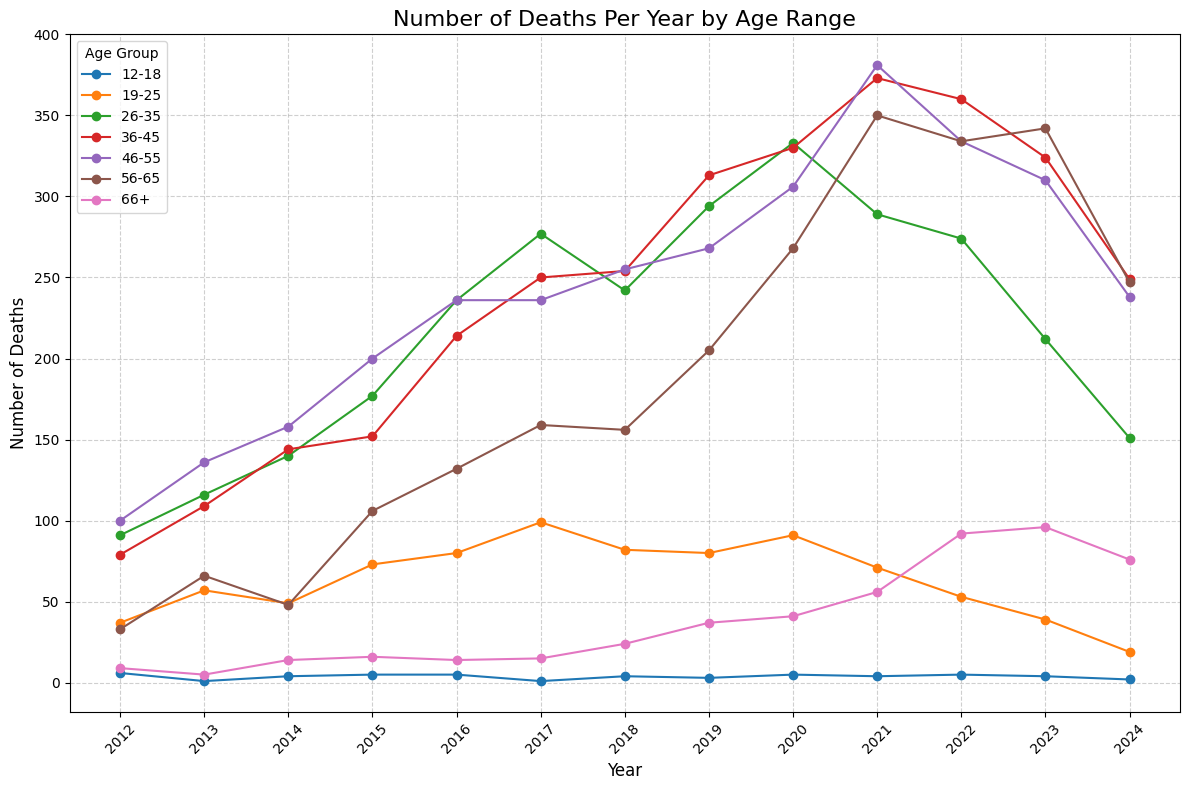

In [30]:
deaths_by_age_year = raw_data.groupby(['Year', 'Age_Range']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 8))
deaths_by_age_year.plot(ax=ax, marker='o', linestyle='-')

ax.set_title('Number of Deaths Per Year by Age Range', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Deaths', fontsize=12)

ax.set_xticks(deaths_by_age_year.index)
ax.tick_params(axis='x', rotation=45)

ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title='Age Group', loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

# To save the plot, uncomment the line below
# plt.savefig('deaths_by_age_range.png')

- The number of deaths per year vary with age categories. 
- Relatively stable number of deaths per year for teenagers and young adults (19-25). 

#### Gender and Number of Deaths Per Year

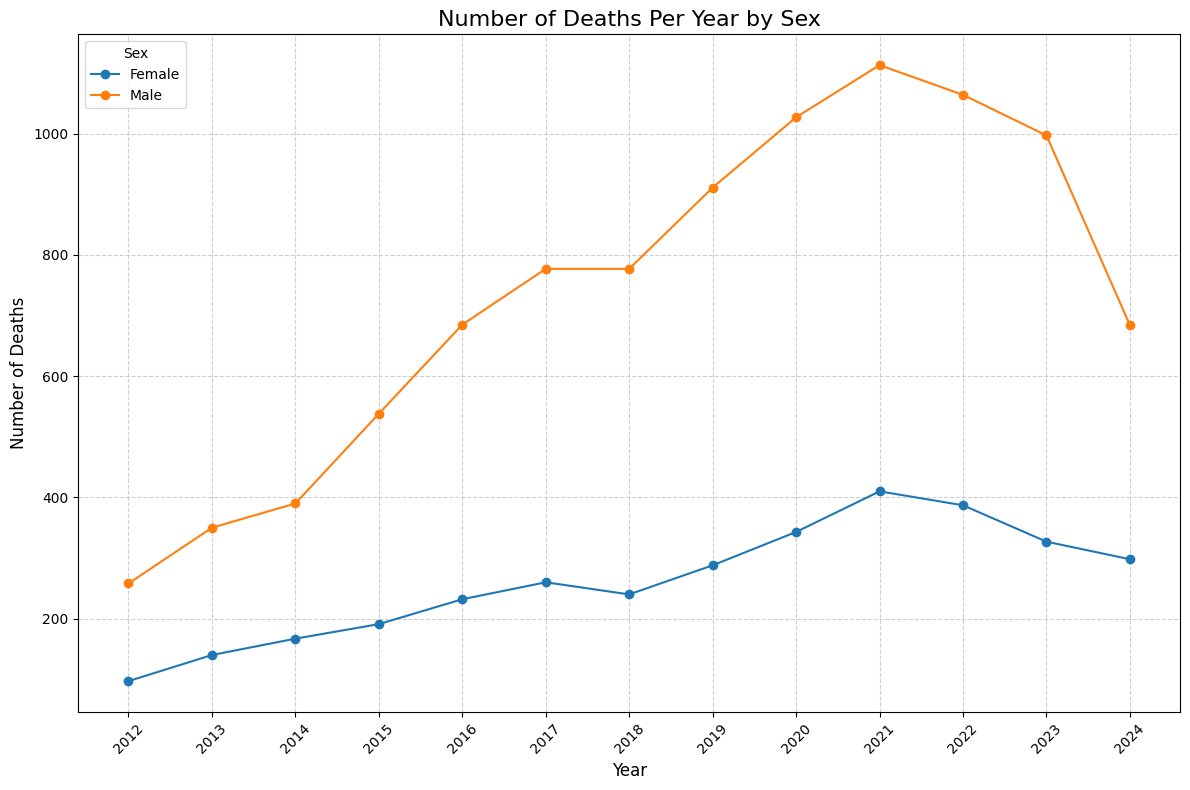

In [31]:
deaths_by_age_year = raw_data.groupby(['Year', 'Sex']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 8))
deaths_by_age_year.plot(ax=ax, marker='o', linestyle='-')

ax.set_title('Number of Deaths Per Year by Sex', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Deaths', fontsize=12)

ax.set_xticks(deaths_by_age_year.index)
ax.tick_params(axis='x', rotation=45)

ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title='Sex', loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

# To save the plot, uncomment the line below
# plt.savefig('deaths_by_age_range.png')

- Greater increase in deaths per year among Males (vs Females)

In [32]:
raw_data['Death County'] = raw_data['Death County'].str.lower()
death_counts = raw_data['Death County'].value_counts()

# Step 2: Load a GeoJSON file of Connecticut towns
# You will need to download a GeoJSON file for CT towns and place it in the same directory as your script.
# You can find one from a resource like the U.S. Census Bureau or a state GIS portal.
try:
    ct_towns = gpd.read_file("ct_counties.geojson")
except FileNotFoundError:
    print("Error: ct_counties.geojson not found. Please provide a GeoJSON file of CT towns.")
    exit()

ct_towns['County'] = ct_towns['County'].str.lower()
ct_towns['County'] = ct_towns['County'].str.removesuffix(' county')
# The 'left' merge ensures all towns are included on the map, even if they have 0 deaths.
merged_data = ct_towns.merge(death_counts.rename('num_deaths'), left_on='County', right_index=True, how='left')

# Fill any towns with 0 deaths (not in your data) with 0
merged_data['num_deaths'] = merged_data['num_deaths'].fillna(0)

/var/folders/jl/6cpcgscn66v90thk48s_d56r0000gn/T/ipykernel_64459/324369147.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_data.geometry.centroid.x,
/var/folders/jl/6cpcgscn66v90thk48s_d56r0000gn/T/ipykernel_64459/324369147.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_data.geometry.centroid.y,


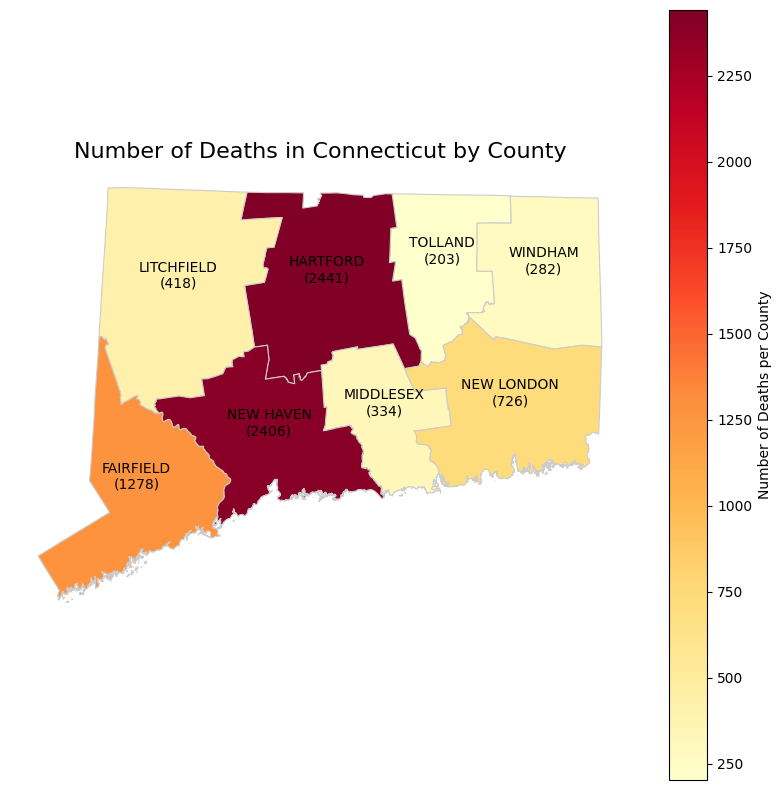

In [33]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

merged_data.plot(
    column='num_deaths',
    cmap='YlOrRd',  # A sequential colormap (light yellow to dark red)
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Number of Deaths per County",
                 'orientation': "vertical"}
)

for x, y, label, count in zip(
    merged_data.geometry.centroid.x,
    merged_data.geometry.centroid.y,
    merged_data['County'],
    merged_data['num_deaths']
):
    ax.annotate(
        text=f"{label.upper()}\n({int(count)})",
        xy=(x, y),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center',
        fontsize=10,
        color='black'
    )
ax.set_title('Number of Deaths in Connecticut by County', fontsize=16)
ax.set_axis_off()

plt.savefig('ct_deaths_map.png', dpi=300)

# Display the plot
plt.show()




- The largest amount of Deaths are in Hartford, and then New Haven County. Fairfield also has a large amount of deaths. 

### Use of Specific Drugs

In [34]:
raw_data.columns.values

array(['Date', 'Date Type', 'Age', 'Sex', 'Race', 'Ethnicity',
       'Residence City', 'Residence County', 'Residence State',
       'Injury City', 'Injury County', 'Injury State', 'Injury Place',
       'Description of Injury', 'Death City', 'Death County',
       'Death State', 'Location', 'Location if Other', 'Cause of Death',
       'Manner of Death', 'Other Significant Conditions ', 'Heroin',
       'Heroin death certificate (DC)', 'Cocaine', 'Fentanyl',
       'Fentanyl Analogue', 'Oxycodone', 'Oxymorphone', 'Ethanol',
       'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Meth/Amphetamine',
       'Amphet', 'Tramad', 'Hydromorphone', 'Morphine (Not Heroin)',
       'Xylazine', 'Gabapentin', 'Opiate NOS', 'Heroin/Morph/Codeine',
       'Other Opioid', 'Any Opioid', 'Other', 'ResidenceCityGeo',
       'InjuryCityGeo', 'DeathCityGeo', 'Age_Range', 'InjuryCity',
       'DeathCity', 'Location_Cleaned', 'Location_Cleaned_Plot', 'Year'],
      dtype=object)

In [35]:
drug_columns = [
    'Cocaine', 'Fentanyl',
    'Fentanyl Analogue', 'Oxycodone', 'Oxymorphone', 'Ethanol',
    'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Meth/Amphetamine',
    'Amphet', 'Tramad', 'Hydromorphone',
    'Xylazine', 'Gabapentin', 'Opiate NOS', 'Heroin/Morph/Codeine',
    'Other Opioid', 'Any Opioid', 'Other'
]

drug_use = raw_data[drug_columns]
drug_use.head()
drug_use = drug_use

#### Bar Plot Comparing Counts of Drug Use

In [38]:
drug_use.head()

,Cocaine,Fentanyl,Fentanyl Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Meth/Amphetamine,Amphet,Tramad,Hydromorphone,Xylazine,Gabapentin,Opiate NOS,Heroin/Morph/Codeine,Other Opioid,Any Opioid,Other
0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,1.0,NaN
3,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


/var/folders/jl/6cpcgscn66v90thk48s_d56r0000gn/T/ipykernel_64459/1004511977.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_use[col] = pd.to_numeric(drug_use[col], errors='coerce')


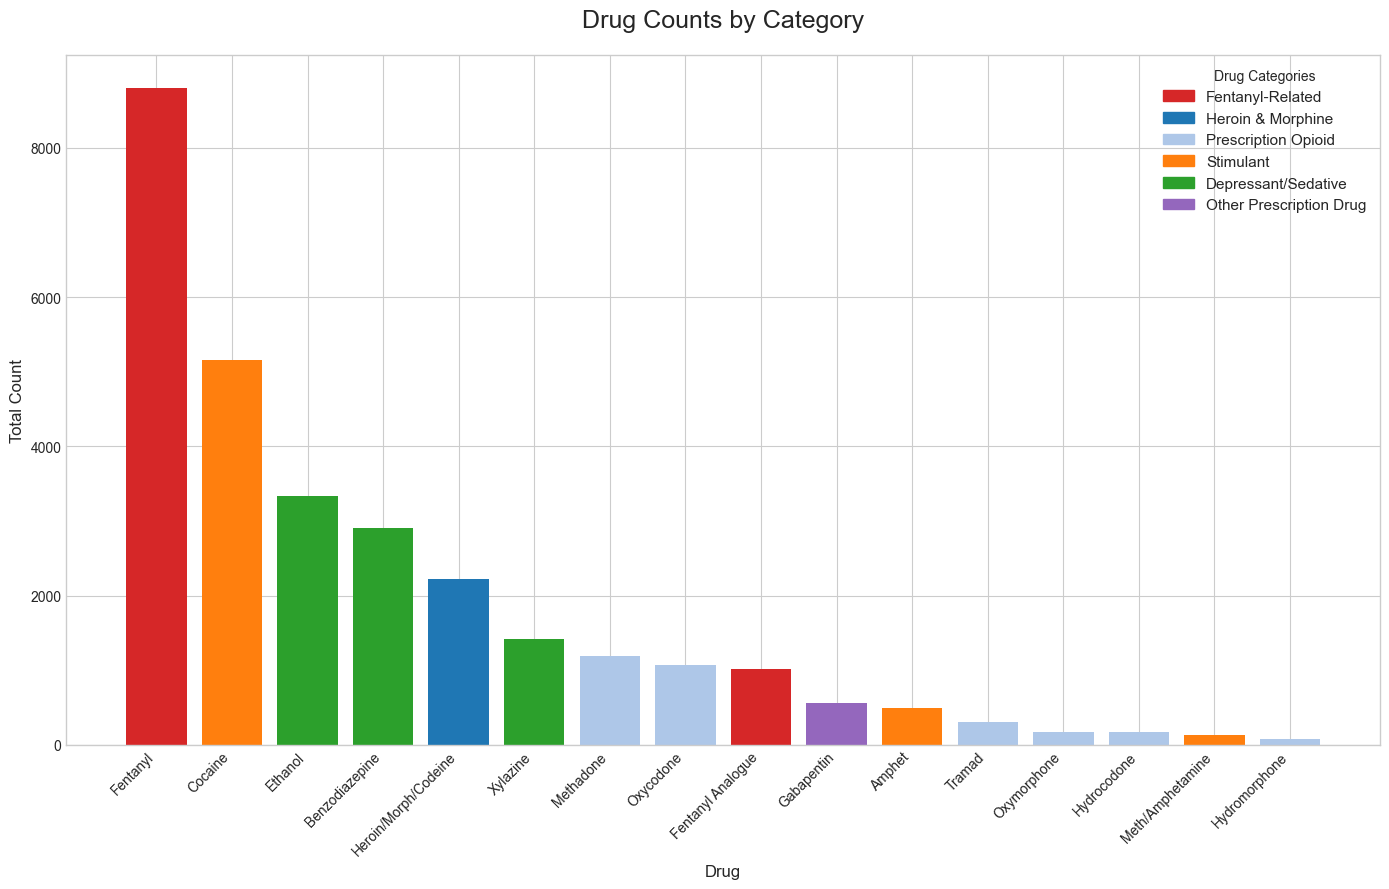

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Convert all columns to numeric, forcing errors into 'NaN' (Not a Number)
for col in drug_use.columns:
    drug_use[col] = pd.to_numeric(drug_use[col], errors='coerce')

# Now the sum() operation will work, as it automatically skips NaN values
drug_counts = drug_use.sum().sort_values(ascending=False)
drug_counts = drug_counts[drug_counts > 0] # Remove drugs with zero count

summary_drugs_to_remove = ['Any Opioid', 'Opiate NOS', 'Other Opioid']
drug_counts = drug_counts[~drug_counts.index.isin(summary_drugs_to_remove)]

# 2. Define the groups and color palette
group_mapping = {
    'Fentanyl': 'Fentanyl-Related', 'Fentanyl Analogue': 'Fentanyl-Related',
    'Heroin/Morph/Codeine': 'Heroin & Morphine',
    'Oxycodone': 'Prescription Opioid', 'Methadone': 'Prescription Opioid',
    'Tramad': 'Prescription Opioid', 'Oxymorphone': 'Prescription Opioid',
    'Hydrocodone': 'Prescription Opioid', 'Hydromorphone': 'Prescription Opioid',
    'Cocaine': 'Stimulant', 'Amphet': 'Stimulant', 'Meth/Amphetamine': 'Stimulant',
    'Ethanol': 'Depressant/Sedative', 'Benzodiazepine': 'Depressant/Sedative',
    'Xylazine': 'Depressant/Sedative',
    'Gabapentin': 'Other Prescription Drug',
    'Any Opioid': 'Summary Category', 'Opiate NOS': 'Summary Category',
    'Other Opioid': 'Summary Category'
}

color_palette = {
    'Fentanyl-Related': '#d62728',      # Red
    'Heroin & Morphine': '#1f77b4',     # Blue
    'Prescription Opioid': '#aec7e8',   # Light Blue
    'Stimulant': '#ff7f0e',             # Orange
    'Depressant/Sedative': '#2ca02c',   # Green
    'Other Prescription Drug': '#9467bd' # Purple
}

# 3. Create a list of colors for the plot based on the drug's group
bar_colors = drug_counts.index.map(group_mapping).map(color_palette)

# 4. Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 9))

plt.bar(drug_counts.index, drug_counts.values, color=bar_colors)

# 5. Create a custom legend
legend_patches = [mpatches.Patch(color=color, label=group) for group, color in color_palette.items()]
plt.legend(handles=legend_patches, title="Drug Categories", fontsize=11)

# Add titles and labels
plt.title('Drug Counts by Category', fontsize=18, pad=20)
plt.ylabel('Total Count', fontsize=12)
plt.xlabel('Drug', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
plt.savefig('drug_counts_by_category.png')
plt.show()

- Fentanyl accounts for the largest number of deaths overall, followed by cocaine. 

### Bar Plot Comparing Single vs Poly Drug Use

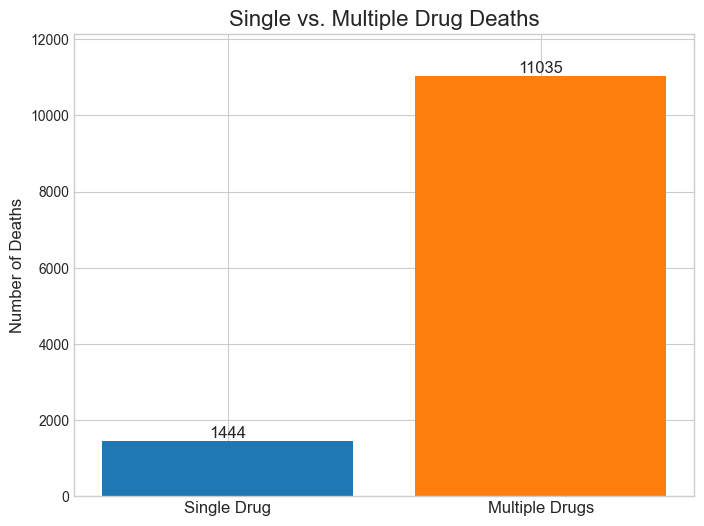

Single Drug Deaths: 1444
Multiple Drug Deaths: 11035


In [47]:
summary_drugs_to_remove = ['Any Opioid', 'Opiate NOS', 'Other Opioid']
drug_use = drug_use[~drug_use.index.isin(summary_drugs_to_remove)]

drug_counts_per_case = drug_use.sum(axis=1)


single_drug_deaths = (drug_counts_per_case == 1).sum()
multiple_drug_deaths = (drug_counts_per_case >= 2).sum()

# Prepare data for plotting
plot_data = {
    'Single Drug': single_drug_deaths,
    'Multiple Drugs': multiple_drug_deaths
}
categories = list(plot_data.keys())
counts = list(plot_data.values())

# Create the bar plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))

bars = plt.bar(categories, counts, color=['#1f77b4', '#ff7f0e'])

# Add text labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=12)

# Add titles and labels
plt.title('Single vs. Multiple Drug Deaths', fontsize=16)
plt.ylabel('Number of Deaths', fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(0, max(counts) * 1.1) # Give some space for the text labels

# Save and show the plot
plt.savefig('single_vs_multiple_drugs.png')
plt.show()

print(f"Single Drug Deaths: {single_drug_deaths}")
print(f"Multiple Drug Deaths: {multiple_drug_deaths}")

The vast majority of deaths occur with polydrug use, rather than just use of a single drug. 

### Single Drug Use - Main Drugs Used

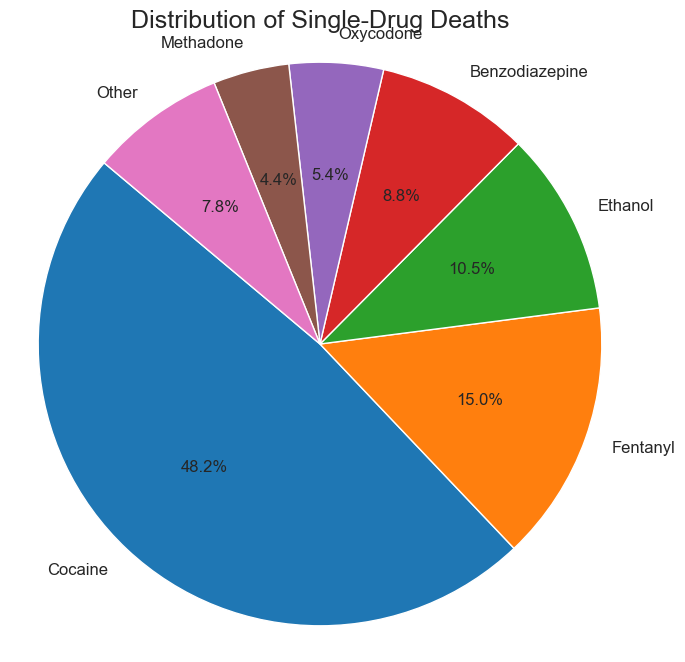

Counts of each drug in single-drug deaths:
Cocaine                 696.0
Fentanyl                216.0
Ethanol                 152.0
Benzodiazepine          127.0
Oxycodone                78.0
Methadone                63.0
Amphet                   40.0
Any Opioid               29.0
Hydrocodone              11.0
Tramad                    9.0
Opiate NOS                7.0
Meth/Amphetamine          6.0
Oxymorphone               4.0
Hydromorphone             2.0
Gabapentin                2.0
Xylazine                  1.0
Heroin/Morph/Codeine      1.0
dtype: float64


In [ ]:
single_drug_cases_df = drug_use[drug_counts_per_case == 1]

# Count which drugs were involved in these single-drug cases
single_drug_counts = single_drug_cases_df.sum().sort_values(ascending=False)

# Filter out any drugs that have a count of zero
single_drug_counts = single_drug_counts[single_drug_counts > 0]

# Prepare the data for the pie chart (grouping smaller slices)
top_n = 6
if len(single_drug_counts) > top_n:
    pie_data = single_drug_counts.head(top_n).copy()
    pie_data['Other'] = single_drug_counts.iloc[top_n:].sum()
else:
    pie_data = single_drug_counts

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 8))

plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140,
        wedgeprops={'edgecolor': 'white'}, textprops={'fontsize': 12})

plt.title('Distribution of Single-Drug Deaths', fontsize=18)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Save and show the plot
plt.savefig('single_drug_pie_chart.png')
plt.show()

print("Counts of each drug in single-drug deaths:")
print(single_drug_counts)


- Cocaine use accounted for the deaths of almost half of all the people who's deaths were related to the use of just one drug (vs multiple). 

In [57]:
drug_use['Year'] = raw_data['Year']
drug_use = drug_use[~drug_use.index.isin(summary_drugs_to_remove)]



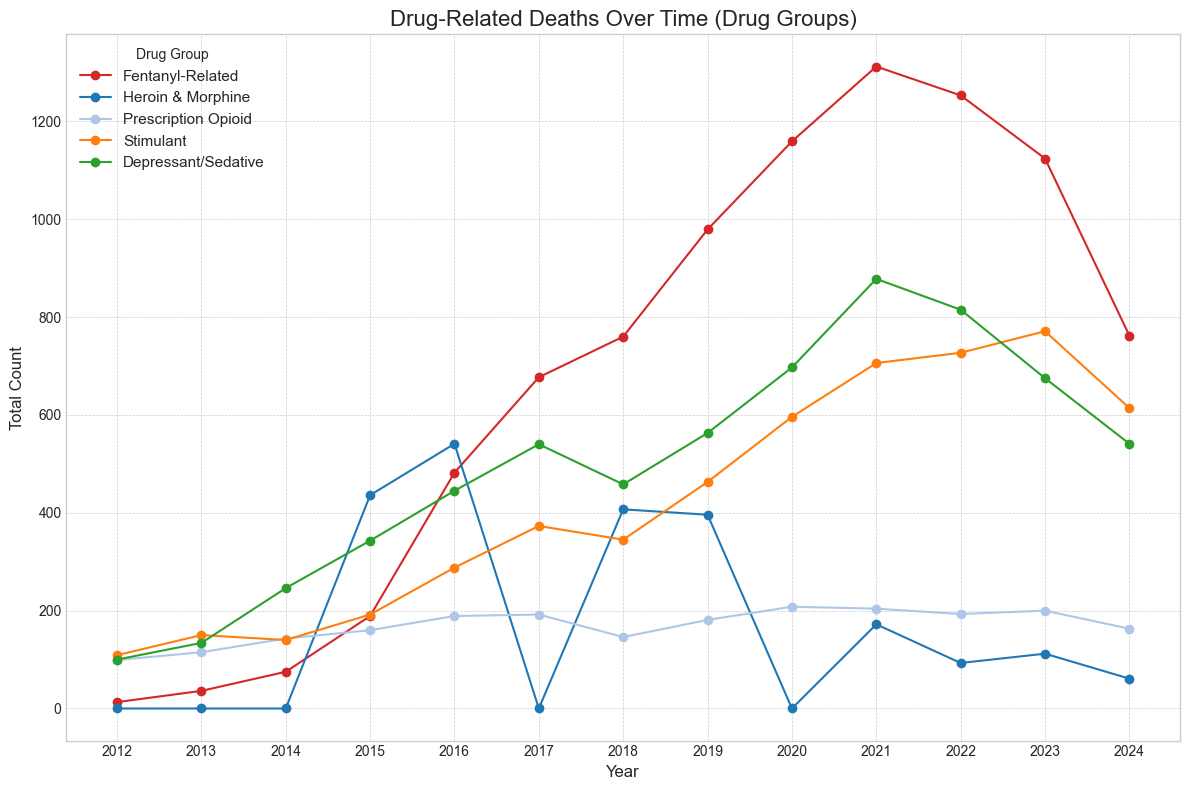

Yearly drug group counts:
      Fentanyl-Related  Heroin & Morphine  Prescription Opioid  Stimulant  \
Year                                                                        
2012                13                  0                   99        109   
2013                36                  0                  115        150   
2014                75                  0                  143        140   
2015               189                436                  160        192   
2016               482                541                  189        288   
2017               677                  0                  192        373   
2018               760                407                  146        345   
2019               979                396                  181        463   
2020              1159                  0                  208        596   
2021              1312                172                  204        706   
2022              1253                 93         

In [61]:
group_mapping = {
    'Fentanyl': 'Fentanyl-Related', 'Fentanyl Analogue': 'Fentanyl-Related',
    'Heroin/Morph/Codeine': 'Heroin & Morphine',
    'Oxycodone': 'Prescription Opioid', 'Methadone': 'Prescription Opioid',
    'Cocaine': 'Stimulant', 'Amphet': 'Stimulant',
    'Ethanol': 'Depressant/Sedative', 'Benzodiazepine': 'Depressant/Sedative',
    'Xylazine': 'Depressant/Sedative'
}
color_palette = {
    'Fentanyl-Related': '#d62728', 'Heroin & Morphine': '#1f77b4',
    'Prescription Opioid': '#aec7e8', 'Stimulant': '#ff7f0e',
    'Depressant/Sedative': '#2ca02c'
}

grouped_drug_df = pd.DataFrame({'Year': drug_use['Year']})
for group_name in color_palette.keys():
    # Find all drugs that belong to the current group
    drugs_in_group = [drug for drug, group in group_mapping.items() if group == group_name]
    # Check if ANY drug in the group was present for each case (row)
    grouped_drug_df[group_name] = drug_use[drugs_in_group].any(axis=1).astype(int)

yearly_group_counts = grouped_drug_df.groupby('Year').sum()

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

yearly_group_counts.plot(kind='line', marker='o', color=[color_palette[col] for col in yearly_group_counts.columns], ax=plt.gca())

plt.title('Drug-Related Deaths Over Time (Drug Groups)', fontsize=16)
plt.ylabel('Total Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(yearly_group_counts.index)
plt.legend(title='Drug Group', fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig('drug_group_trends.png')
plt.show()

print("Yearly drug group counts:")
print(yearly_group_counts)

- Since around 2017, Fentanyl-related drug-related deaths began overtake the drug-related deaths for other substances.